In [22]:
import pandas as pd
import movingpandas as mpd
import glob
import os, json, sys
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from datetime import datetime
import folium
from folium import plugins
from folium.features import DivIcon
import geopandas
from datetime import datetime, timedelta
from tqdm import tqdm
from shapely.geometry import Polygon

In [4]:
path_to_json = '../../data/ais-hub/*'

json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

dfs = [] # an empty list to store the data frames
for file in tqdm(file_list):
    data = pd.read_json(file, lines=True) # read data frame from json file
    data['absolute-time'] = pd.json_normalize(data['meta-data'])['absolute-time']
    dfs.append(data) # append the data frame to the list

temp = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.

100%|██████████| 8260/8260 [03:27<00:00, 39.79it/s]


## Preprocessing dataframe

In [5]:
df = temp[['longitude', 'latitude', 'absolute-time', 'source-mmsi', 'navigational-status', 'rate-of-turn', 'speed-over-ground', 'position-accuracy', 'course-over-ground', \
          'true-heading', 'type' ]]

# remove rows with NaNs (just 'navigational-status' and 'rate-of-turn')
df = df.dropna()
df = df.rename(columns={'longitude': 'lon', 'latitude': 'lat', 'absolute-time': 'timestamp', 'source-mmsi': 'mmsi',\
    'navigational-status': 'nav_status', 'rate-of-turn': 'rot', 'speed-over-ground': 'sog', 'position-accuracy': 'acc', 'course-over-ground': 'cog',\
    'true-heading': 'heading'})

In [6]:
# remove "standing still in habour" and ship moving too slow
df = df[df.sog>3]
df = df[(df.lon<180) | (df.lat<90)]

## Filter unrealistic sog values (over 100 for example)
df = df[df.sog<=30]

# convert to GeoDataFrame
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(x=df.lon, y=df.lat), crs="WGS84"
)
gdf['time'] = pd.to_datetime(gdf['timestamp'], unit='ms')
gdf = gdf.set_index('time')

## Generate Trajectory Collection with MovingPandas

In [7]:
# Specify minimum length for a trajectory (in meters)
minimum_length = 30 
collection = mpd.TrajectoryCollection(gdf, 'mmsi', min_length=minimum_length)

In [ ]:
# (optional) add calculated speed and direction direct from the lat/lon position of the vessel.
# This should not be necessary as we will use the pure interpolated real values!

#collection.add_speed(overwrite=True)
#collection.add_direction(overwrite=True)

In [9]:
# Remove Trajectories that have too long gaps in consecutive AIS signals
trips = mpd.ObservationGapSplitter(collection).split(gap=timedelta(minutes=5))
# Remove all anchoring chips with a tolerance of 15 diameter (for example the Tugs laying in the "Schlepperhafen")
trips = mpd.StopSplitter(trips).split(max_diameter=15, min_duration=timedelta(minutes=3), min_length=200)
# Outlier detecting and cleaning (Outlier (interquantile range - iqr) based cleaner.)
# From moving pandas: "Note: Setting alpha=3 is widely used."
trips = mpd.OutlierCleaner(trips).clean({'sog': 3})

In [27]:
# hand-made polygon of the area of interest which excludes the inner harbour and floodgates
# (basically just the Weser)
area_of_intereset = Polygon([(8.4867561,53.486203), (8.4867923,53.4861983), (8.5063362,53.4849813), (8.5257339,53.4990238), (8.5642719,53.5098972), \
(8.5717392,53.51939), (8.574357,53.5290337), (8.5766745,53.5363798), (8.576932,53.5390577), (8.5747862,53.5414678), \
(8.5707736,53.5437884), (8.5686493,53.5459176), (8.561182,53.5540766), (8.5582638,53.5545865), (8.5471916,53.566669), \
(8.5452175,53.5694215), (8.5317421,53.5859837), (8.5214424,53.6045765), (8.5198975,53.6112475), (8.501358,53.6405673), \
(8.4965515,53.6747479), (8.6160278,53.8760117), (8.0900574,53.9019109), (8.1202698,53.6373105), (8.3262634,53.6092107), \
(8.3468628,53.5937274), (8.4555244,53.5527509), (8.5322571,53.5392873), (8.5497665,53.5361247), (8.5537148,53.5312274), \
(8.5533714,53.5264316), (8.5487366,53.5233702), (8.5336304,53.5176549), (8.5180092,53.5108159), (8.5027313,53.5016276), \
(8.4867561,53.486203)])

# TODO not working at all (returns 0 trajectories)
# clipped_trips = trips.clip(area_of_intereset)

In [ ]:
trips.trajectories[2].plot(column="speed", linewidth=5, capstyle='round', legend=True)

In [11]:
def resample_and_interpolate(trips, resample_interval="5S", interpolate_method="linear"):
    out = pd.DataFrame()

    for t in tqdm(trips.trajectories):
        tmp = t.df.resample(resample_interval, origin="end").mean()
        tmp["mmsi"].interpolate(method="bfill", inplace=True)
        tmp["nav_status"].interpolate(method="bfill", inplace=True)
        tmp["sog"].interpolate(method=interpolate_method, inplace=True)
        tmp["cog"].interpolate(method=interpolate_method, inplace=True)
        tmp["lat"].interpolate(method=interpolate_method, inplace=True)
        tmp["lon"].interpolate(method=interpolate_method, inplace=True)
        tmp["traj_id"] = str(tmp["mmsi"][0]) + str(tmp.iloc[0].name)
        tmp["timestamp"] = tmp.index
        tmp.reset_index(drop=True, inplace=True)
        out = out.append(tmp)
        
    return out

In [12]:
linear_out = resample_and_interpolate(trips, resample_interval='5S', interpolate_method='linear')
linear_out


100%|██████████| 28941/28941 [39:23<00:00, 12.25it/s]


,lon,lat,timestamp,mmsi,nav_status,rot,sog,acc,cog,heading,type,traj_id
0,8.489295,53.612557,2020-07-27 02:26:25.751,72434416.0,0.0,0.0,10.200000,1.0,133.500000,139.0,1.0,72434416.02020-07-27 02:26:25.751000
1,8.489539,53.612384,2020-07-27 02:26:30.751,72434416.0,0.0,NaN,10.185714,NaN,133.658929,NaN,NaN,72434416.02020-07-27 02:26:25.751000
2,8.489782,53.612210,2020-07-27 02:26:35.751,72434416.0,0.0,NaN,10.171429,NaN,133.817858,NaN,NaN,72434416.02020-07-27 02:26:25.751000
3,8.490026,53.612037,2020-07-27 02:26:40.751,72434416.0,0.0,NaN,10.157143,NaN,133.976786,NaN,NaN,72434416.02020-07-27 02:26:25.751000
4,8.490269,53.611864,2020-07-27 02:26:45.751,72434416.0,0.0,NaN,10.142857,NaN,134.135715,NaN,NaN,72434416.02020-07-27 02:26:25.751000
...,...,...,...,...,...,...,...,...,...,...,...,...
974,8.500859,53.491402,2020-10-01 10:16:25.125,664444000.0,0.0,NaN,12.300000,NaN,207.928579,NaN,NaN,664444000.02020-10-01 08:55:15.125000
975,8.500615,53.491147,2020-10-01 10:16:30.125,664444000.0,0.0,NaN,12.300000,NaN,207.671436,NaN,NaN,664444000.02020-10-01 08:55:15.125000
976,8.500372,53.490892,2020-10-01 10:16:35.125,664444000.0,0.0,NaN,12.300000,NaN,207.414294,NaN,NaN,664444000.02020-10-01 08:55:15.125000
977,8.500128,53.490637,2020-10-01 10:16:40.125,664444000.0,0.0,NaN,12.300000,NaN,207.157152,NaN,NaN,664444000.02020-10-01 08:55:15.125000


In [13]:
linear_out.to_csv("trajectories_aishub_linear.csv", index=False)

In [32]:
linear_out[linear_out["sog"] <= 30]["lon"].min()

8.372

In [ ]:
df = pd.DataFrame({'lon':[8.5106277, 8.5363770, 8.5394669, 8.5411835, 8.5442734], 'lat': [53.5957650, 53.5786462, 53.5686570, 53.5611125, 53.5551984]})

m = folium.Map(location=[53.54, 8.56])
coordinates = np.vstack((df['lat'], df['lon'])).T
data_tuples = list(zip(df["lat"], df["lon"]))
line = folium.PolyLine(coordinates,
    weight=1,
    color="black",
).add_to(m)
attr = {"font-weight": "bold", "font-size": "24"}
plugins.PolyLineTextPath(line, line_color='#FF0000', line_weight=5, attributes=attr, text="").add_to(m)
for tuple in data_tuples:
    #folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=1 ).add_to( m )
    folium.CircleMarker(location=[tuple[0], tuple[1]], radius=2, popup=f'lat:{tuple[0]},  lon: {tuple[1]}, time: {tuple[1]} mmsi:').add_to(m)
    #folium.Marker(location=[tuple[0][0], tuple[0][1]], icon=DivIcon(icon_size=(150,36), icon_anchor=(-13,0),
    #    html='<div style="font-size: 8pt;">{}</div>'.format(tuple[1]))).add_to(m)
m

In [ ]:
import contextily as ctx
from IPython.display import clear_output
import time

plt.ion()
west, south, east, north = (
    df["lon"].min(),
    df["lat"].min(),
    df["lon"].max(),
    df["lat"].max()
             )

ghent_img, ghent_ext = ctx.bounds2img(west,
                                     south,
                                     east,
                                     north,
                                     ll=True,
                                     source=ctx.providers.OpenStreetMap.Mapnik
                                    )

f, ax = plt.subplots(1, figsize=(9, 9))
plt.imshow(ghent_img, extent=ghent_ext)
plt.plot(df["lat"], df["lon"])
plt.show()


<AxesSubplot:>

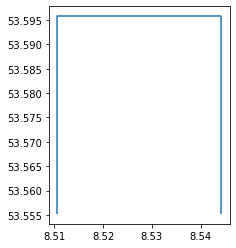

In [81]:
#geopandas.GeoSeries(map(Point, zip(df["lat"], df["lon"])).unary_union).boundary
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df["lon"],df["lat"]))


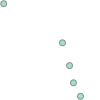

In [64]:
gdf.geometry.unary_union

In [130]:
df["lon"][0:2]

0    8.510628
1    8.536377
Name: lon, dtype: float64

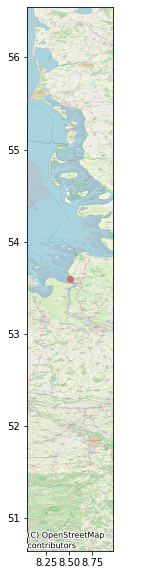

<Figure size 432x288 with 0 Axes>

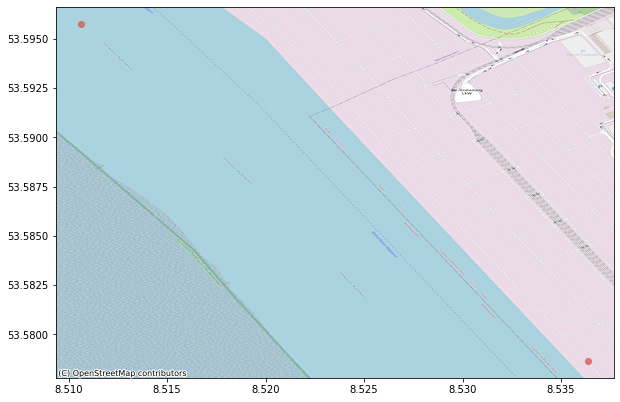

<Figure size 432x288 with 0 Axes>

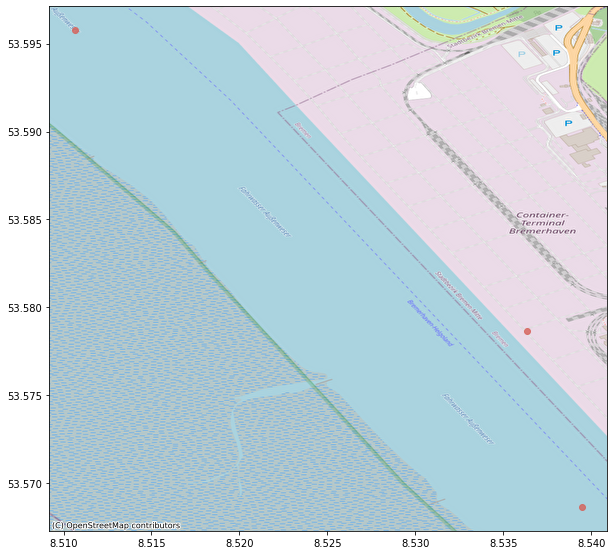

<Figure size 432x288 with 0 Axes>

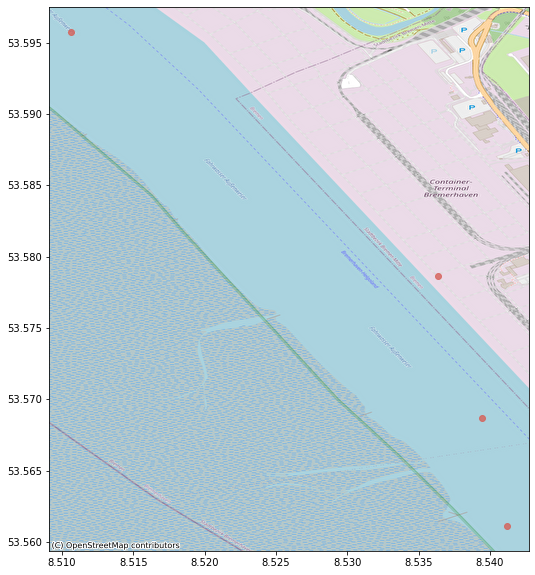

<Figure size 432x288 with 0 Axes>

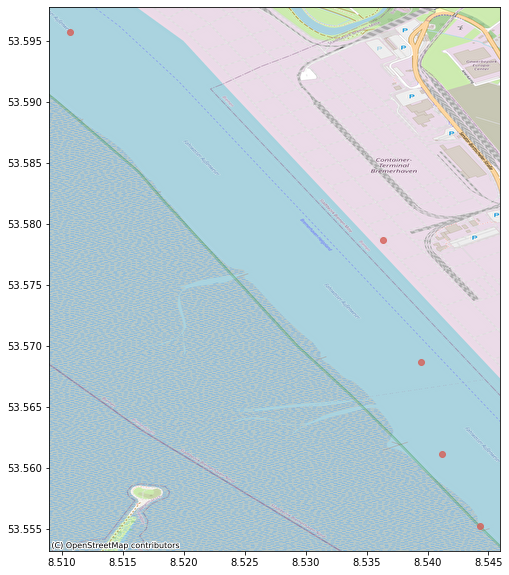

<Figure size 432x288 with 0 Axes>

In [137]:
from shapely.geometry import Point, LineString

xmin = df["lon"].min()
xmax = df["lon"].max()
ymin = df["lat"].min()
ymax = df["lat"].max()
for i in range(1,5):
    gdf = geopandas.GeoDataFrame(
        df[0:i], geometry=geopandas.points_from_xy(df["lon"][0:i],df["lat"][0:i]))

    plt.ion()
    ax.set_xlim(8.4,8.6)
    ax.set_ylim(53.4, 53.9)
    ax = gdf.plot(alpha=0.80, color='#d66058', figsize=(10,10))
    ctx.add_basemap(ax, crs="epsg:4326", source=ctx.providers.OpenStreetMap.Mapnik, interpolation="sinc")
    plt.draw()
    plt.pause(0.0001)
    plt.clf()
    time.sleep(0.01)

